<font size=6><b> KLUE-Bert 기반 뉴스 감성분류 모델 (학습 및 평가)

* References
    - PLM(KLUE/Bert-base): https://huggingface.co/klue/bert-base
    - https://github.com/park-gb/financial-news-sentiment-classifier
* Dataset:
    - 한국경제 경제뉴스 데이터 
    - FinancialPhraseBank Dataset : https://github.com/ukairia777/finance_sentiment_corpus/blob/main/finance_data.csv

# 패키지 설치

* KLUE-Bert model은 transformers 기반

In [112]:
# !pip install transformers

* RAdam Optimizer 관련 패키지

In [113]:
# !pip install ./datasets/orflow_addons

<!-- ## RAdam 패키지 설치
- Optimizer로써 Rectified Adam을 사용할 예정입니다. -->

# 패키지 import

In [114]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

import warnings
warnings.filterwarnings(action='ignore')

# 언어모델 및 Tokenizer 불러오기
- Hugging Face에서 간편하게 Pretrained 언어 모델과 tokenizer를 불러옴.
- [KLUE Bert-base 모델](https://huggingface.co/klue/bert-base)을 활용.

In [115]:
MODEL_NAME = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# GPU 작동확인
- 모델을 학습하고, 예측하는 과정에서 많은 연산을 필요로하고 속도가 아주 느리기 때문에  
Colab을 활용하여 GPU 환경에서 진행하기를 권장.

In [116]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print("GPU 작동 중")
    mirrored_strategy = tf.distribute.MirroredStrategy()
else:
    print("GPU 미작동 중")

GPU 미작동 중


# 경제 뉴스 감정 데이터셋 로드

## FinancialPhraseBank Dataset
- ref: [Github @Ukairia777](https://github.com/ukairia777/finance_sentiment_corpus/blob/main/finance_data.csv)

In [117]:
DATASET_URL = "https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv"
DATASET_NAME = "./datasets/finance_data.csv"

urllib.request.urlretrieve(DATASET_URL,filename = DATASET_NAME)

('./datasets/finance_data.csv', <http.client.HTTPMessage at 0x230eeb10100>)

In [118]:
dataset = pd.read_csv(DATASET_NAME)
dataset.head()

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


### 데이터 전처리

In [119]:
# 영어 뉴스 기사 칼럼 제거
del dataset['sentence']

In [120]:
# 라벨 데이터 숫자 치환
dataset['labels'] = dataset['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
dataset.head()

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [121]:
# 중복 데이터 확인
dataset[dataset['kor_sentence'].duplicated()]

,labels,kor_sentence
79,1,텔레콤월드와이어-2006년 4월 7일-TJ 그룹은 모닝 디지털 디자인 Oy 핀란드 ...
789,0,그룹의 사업은 스포츠의 광범위한 포트폴리오와 모든 주요 시장에서의 입지에 의해 균형...
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.
1394,0,"핀란드 헬싱키에 본사를 둔 레민카이넨 그룹은 토목 공학, 건축 계약, 기술 건축 서..."
1416,0,"이 보고서는 블랙 앤 데커, 피스카스, 피스카스 브랜드, 후스크바르나 아웃도어 프로..."
2396,0,알스트롬의 주가는 나스닥 OMX 헬싱키에서 인용되고 있다.
2567,0,SSH 통신 보안 코퍼레이션은 핀란드 헬싱키에 본사를 두고 있다.
2889,0,재정적인 세부사항은 공개되지 않았다.
2890,0,재정적인 세부사항은 공개되지 않았다.
2892,0,금융 조건은 공개되지 않았다.


In [122]:
# 중복 데이터 제거
dataset.drop_duplicates(subset = ['kor_sentence'], inplace = True)
dataset.head()

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


# 한경 경제뉴스 데이터셋

In [124]:
hkdf = pd.read_csv('./datasets/news_train_labeling.csv')
hkdf.head()

,kor_sentence,labels
0,상저하고? 상고하저?…'눈물의 손절' 올해는 다를까 [2023 증시전망 上],0
1,"""올 한국증시, 미국보다 나을 수도""…펀드매니저들 입 모았다 [다시 열자! 3000시대]",0
2,"""1800억 규모 기술 이전""...알테오젠 '강세'",1
3,"아모레퍼시픽, 안세홍 대표이사 사임[주목 e공시]",0
4,(마감)프로그램 290억 매도 우위,2


In [126]:
# 중복 데이터 제거
hkdf.drop_duplicates(subset = ['kor_sentence'], inplace = True)
hkdf.head()

,kor_sentence,labels
0,상저하고? 상고하저?…'눈물의 손절' 올해는 다를까 [2023 증시전망 上],0
1,"""올 한국증시, 미국보다 나을 수도""…펀드매니저들 입 모았다 [다시 열자! 3000시대]",0
2,"""1800억 규모 기술 이전""...알테오젠 '강세'",1
3,"아모레퍼시픽, 안세홍 대표이사 사임[주목 e공시]",0
4,(마감)프로그램 290억 매도 우위,2


In [127]:
hkdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1878 entries, 0 to 1896
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   kor_sentence  1878 non-null   object
 1   labels        1878 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.0+ KB


In [128]:
dataset = pd.concat([dataset, hkdf])
dataset = dataset.reset_index()
dataset = dataset.drop('index', axis=1)
dataset.head()

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


# 라벨별 데이터 분포 확인

6705
0    0.537062
1    0.326324
2    0.136614
Name: labels, dtype: float64


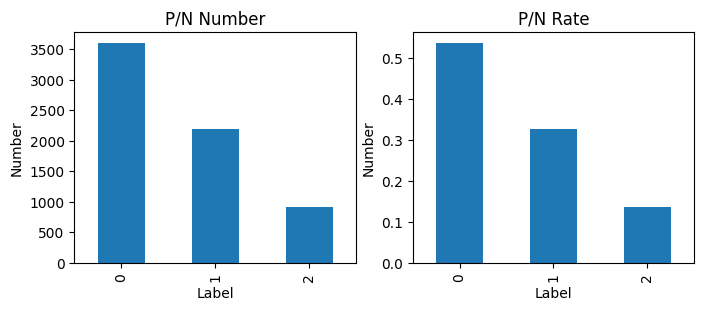

In [129]:
# 중립적인 기사문 53.7%, 긍정적인 기사문 32.61%, 부정적인 기사문 13.68%
print(len(dataset))
print(dataset['labels'].value_counts(normalize = True))

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dataset['labels'].value_counts().plot(kind = 'bar',  ax=axes[0])
axes[0].set_title("P/N Number")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Number")
dataset['labels'].value_counts(normalize = True).plot(kind = 'bar', ax=axes[1])
axes[1].set_title("P/N Rate")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Number")
plt.show()

* negative data 불균형, 복제.

In [130]:
tempdf = dataset[dataset['labels'] ==2]
dataset = pd.concat([dataset, tempdf])
dataset.head()

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


7621
0    0.472510
1    0.287101
2    0.240388
Name: labels, dtype: float64


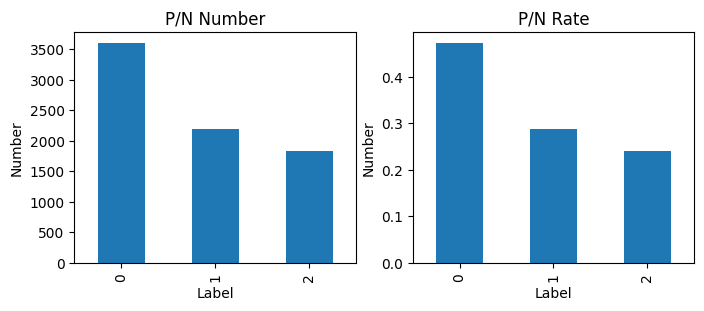

In [131]:
# 부정 뉴스 복제후, 중립적인 기사문 47.23%, 긍정적인 기사문 28.68%, 부정적인 기사문 24.07%
print(len(dataset))
print(dataset['labels'].value_counts(normalize = True))

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dataset['labels'].value_counts().plot(kind = 'bar',  ax=axes[0])
axes[0].set_title("P/N Number")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Number")
dataset['labels'].value_counts(normalize = True).plot(kind = 'bar', ax=axes[1])
axes[1].set_title("P/N Rate")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Number")
plt.show()

# Train/Test 데이터 분리

In [132]:
# 입출력 데이터 분리
X_data = dataset['kor_sentence']
y_data = dataset['labels']

In [133]:
TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 42

# strtify = True 일 경우, 데이터 분리 이전의 라벨별 분포 고려
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y_data)

In [134]:
print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

훈련 입력 데이터 개수: 6096
테스트 입력 데이터 개수: 1525


In [135]:
# 훈련 데이터 라벨별 비율
y_train.value_counts(normalize = True)

0    0.472605
1    0.287073
2    0.240322
Name: labels, dtype: float64

In [136]:
# 테스트 데이터 라벨별 비율
y_test.value_counts(normalize = True)

0    0.472131
1    0.287213
2    0.240656
Name: labels, dtype: float64

# BERT 입력용 데이터 포맷으로 변경

In [137]:
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 64

In [138]:
def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []

    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)

        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros

        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [139]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)

6096it [00:02, 2781.70it/s]


In [140]:
# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

1525it [00:00, 2810.81it/s]


In [ ]:
# X_test.to_csv('./datasets/X_train.csv')

# BERT를 활용한 파인튜닝

In [141]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [142]:
bert_outputs

TFSequenceClassifierOutput(loss=None, logits=<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'tf_bert_for_sequence_classification_4')>, hidden_states=None, attentions=None)

In [143]:
bert_output = bert_outputs[0]

## 감정 분류 모델 컴파일

In [144]:
DROPOUT_RATE = 0.5
NUM_CLASS = 3
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)

# Multi-class classification 문제이므로 activation function은 softmax로 설정
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

In [145]:
# 옵티마이저 Rectified Adam 하이퍼파리미터 조정
LEARNING_RATE = 5e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS,
                                          warmup_proportion = WARMUP_PROPORTION,
                                          min_lr = MIN_LR,
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)

In [146]:
# 감정분류 모델 컴파일
sentiment_model.compile(optimizer = optimizer,
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics = ['accuracy'])

## 조기종료 조건

In [147]:
MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = MIN_DELTA,
    patience = PATIENCE)

## 최고 성능 모델 저장

In [148]:
# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = './model/best_model.h5'

In [149]:
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

In [150]:
callbacks = [early_stopping, model_checkpoint]

## 감정 분류 모델 학습

In [151]:
EPOCHS = 10
BATCH_SZIE = 32

In [ ]:
sentiment_model.fit(train_x, train_y,
                    epochs = EPOCHS,
                    shuffle = True,
                    batch_size = BATCH_SZIE,
                    validation_data = (test_x, test_y),
                    callbacks = callbacks
                    )

# 감정 분류의 예측값 계산

In [152]:
# 최고 성능의 모델 불러오기
sentiment_model_best = tf.keras.models.load_model(BEST_MODEL_NAME,
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [153]:
# 모델이 예측한 라벨 도출
predicted_value = sentiment_model_best.predict(test_x)
predicted_label = np.argmax(predicted_value, axis = 1)

48/48 [==============================] - 130s 3s/step


In [154]:
testdf = pd.DataFrame(X_test)
testdf['pred'] = predicted_label
testdf['target_label'] = test_y
testdf.head()

,kor_sentence,pred,target_label
10,텔리아소네라 TLSN은 이번 제안이 핵심 사업 보유에 대한 지분을 늘리기 위한 전략...,1,1
6521,네이버+카카오+쿠팡+배민 합쳐놓은 플랫폼株가 있다고?,0,0
4520,지역 폐기물 관리 회사인 Turun Seudun J+Aytehulto는 15만 톤의...,0,0
1796,세계지적재산권기구(World Intelligent Property Organizat...,0,0
4359,2009년 10월 식품 판매 총액은 323.5 유로로 2008년 10월에 비해 5....,2,2


In [155]:
testdf.to_csv('./datasets/X_val_result.csv', encoding='cp949')

# 감정 분류 모델의 성능 평가

## Classification Report

In [156]:
cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
cl_report_df

,precision,recall,f1-score,support
0,0.993,0.993,0.993,720.000
1,0.984,0.977,0.981,438.000
2,0.976,0.984,0.980,367.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.984,0.985,0.984,1525.000
weighted avg,0.986,0.986,0.986,1525.000


## Confusion Matrix

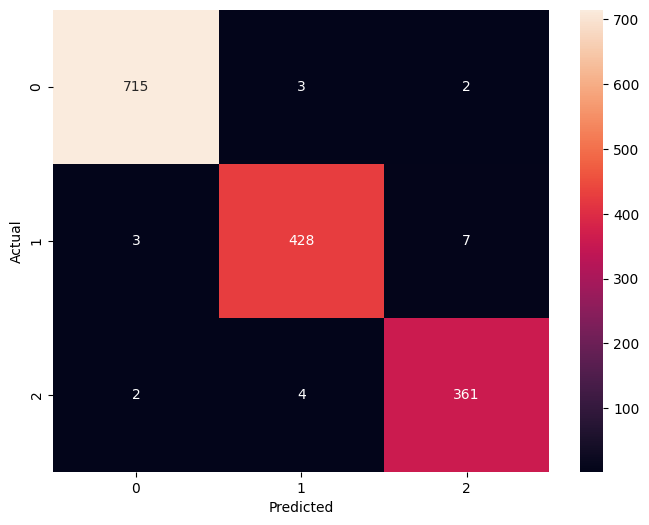

In [157]:
cf_matrix = confusion_matrix(test_y, predicted_label)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 전체 평가지표

In [158]:
# Multi-class Classification의 대중적인 평가 지표 모두 확인
accuracy_score_v = round(accuracy_score(y_test, predicted_label), 3) # Accuracy
precision_score_v = round(precision_score(y_test, predicted_label, average="weighted"), 3) # Precision
recall_score_v = round(recall_score(y_test, predicted_label, average="weighted"), 3) # Recall
f1_score_v = round(f1_score(y_test, predicted_label, average="weighted"), 3) # F1 Score
roc_auc_score_v = round(roc_auc_score(y_test, predicted_value, average="weighted", multi_class="ovr"), 3) # ROC AUC Score
cohen_kappa_score_v = round(cohen_kappa_score(y_test, predicted_label), 3) # Cohen's Kappa Score
matthews_corrcoef_v = round(matthews_corrcoef(y_test, predicted_label), 3) # Matthew's Correlation Coefficient
log_loss_v = round(log_loss(y_test, predicted_value), 3) # Log Loss

In [159]:
# 평가지표 결과
metric_total = pd.DataFrame({
    'PLM': MODEL_NAME,
    'Accuracy': accuracy_score_v,
    'Precision': precision_score_v,
    'Recall': recall_score_v,
    'F1_score': f1_score_v,
    'ROC_AUC_score': roc_auc_score_v,
    'Cohen_kappa_coef': cohen_kappa_score_v,
    'Matthews_corrcoef': matthews_corrcoef_v,
    'Log_loss': log_loss_v},
    index = ['-']
    )

metric_total

,PLM,Accuracy,Precision,Recall,F1_score,ROC_AUC_score,Cohen_kappa_coef,Matthews_corrcoef,Log_loss
-,klue/bert-base,0.986,0.986,0.986,0.986,0.996,0.978,0.978,0.107
